In [7]:
import numpy as np

from abses import Actor, MainModel, PatchCell
from abses.datacollection import DataCollector

# Instantiate random number generator
rng = np.random.default_rng(42)

In [8]:
class Grass(PatchCell):
    """Custom patch cell class"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._empty = False
        self._countdown = 1

    @property
    def empty(self):
        return self._empty

    @empty.setter
    def empty(self, value):
        self._empty = value

    def grow_grass(self):
        # countdown on brown patches: if you reach 0, grow some grass
        if self._empty == True:
            if self._countdown <= 0:
                self._empty = False
                self._countdown = 5
            else:
                self._countdown -= 1

In [15]:
class Animal(Actor):
    def __init__(self, model, rep_rate, *args, **kwargs):
        Actor.__init__(self, model, *args, **kwargs)
        self.energy = 5
        self.rep_rate = rep_rate

    def step(self):
        pass

    def update(self):
        # consume energy
        self.energy -= 1

        if self.energy <= 0:
            self.die()

    def move(self):
        neighborhood = self.layer.get_neighborhood(
            self.pos, moore=True, include_center=False
        )

        # pick new position randomly
        new_pos = rng.choice(neighborhood)
        self.move_to(new_pos)

    def reproduce(self):
        if rng.uniform(0, 1) < self.rep_rate:
            self.energy /= 2
            offspring = self.__class__(
                model=self.model, rep_rate=self.rep_rate
            )
            self.model.agents.add(offspring)
            offspring.put_on_layer(self.layer, self.pos)


class Wolf(Animal):
    def step(self):
        self.move()
        self.eat_sheep()
        self.reproduce()
        self.update()

    def eat_sheep(self):
        x = self.pos[0]
        y = self.pos[1]

        sheep = self.layer.cells[x][y].agents.select("Sheep")
        if len(sheep) > 0:
            sheep[0].die()
            self.energy += 3


class Sheep(Animal):
    def step(self):
        self.move()
        self.eat_grass()
        self.reproduce()
        self.update()

    def eat_grass(self):
        x = self.pos[0]
        y = self.pos[1]

        if self.layer.cells[x][y].empty == False:
            self.layer.cells[x][y].empty = True
            self.energy += 3

In [16]:
class WolfSheepModel(MainModel):
    def __init__(
        self, n_sheep, n_wolves, w_rep_rate, s_rep_rate, shape, *args, **kwargs
    ):
        super().__init__(*args, **kwargs)

        # initialize a grid
        self.nature.create_module(
            how="from_resolution",
            shape=shape,
            cell_cls=Grass,
        )

        self._cells = [
            cell for row in self.nature.major_layer.cells for cell in row
        ]

        # add sheep and wolves
        self.agents.new(Wolf, n_wolves, rep_rate=w_rep_rate)
        self.agents.new(Sheep, n_sheep, rep_rate=s_rep_rate)

        # place both sheep and wolves randomly on the grid, grass dispersed evenly
        for actor in self.actors:
            actor.put_on_layer(
                layer=self.nature.major_layer,
                pos=tuple(
                    [rng.integers(0, shape[0]), rng.integers(0, shape[1])]
                ),
            )

        self.datacollector = DataCollector(
            model=self,
            model_reporters={
                "pop_wolves": lambda m: len(m.actors.select("Wolf")),
                "pop_sheep": lambda m: len(m.actors.select("Sheep")),
            },
        )

    def step(self):
        self.actors.select("Sheep").trigger("step")
        self.actors.select("Wolf").trigger("step")

        # grow grass
        for cell in self._cells:
            cell.grow_grass()

        # end model
        if (
            self.actors.select("Sheep") == []
            and self.actors.select("Wolf") == []
        ):
            self.running = False
        elif len(self.actors.select("Sheep")) >= 400:
            self.running = False

        # collect data
        self.datacollector.collect()

In [17]:
parameters = {
    "time": {
        "end": 200,
    }
}

model = WolfSheepModel(
    n_sheep=200,
    n_wolves=50,
    w_rep_rate=0.1,
    s_rep_rate=0.15,
    shape=(10, 10),
    parameters=parameters,
)
model.run_model()

[2024-02-25 19:08:55][human          ] | Initializing a new Human Module...
[2024-02-25 19:08:55][nature         ] | Initializing a new Base Nature module...
[2024-02-25 19:08:55][nature         ] | Initializing a new Model Layer...
[2024-02-25 19:08:55][nature         ] | Using rioxarray version: 0.13.4
[2024-02-25 19:08:55][container      ] | Created 50 actors of breed Wolf
[2024-02-25 19:08:55][container      ] | Created 200 actors of breed Sheep
[2024-02-25 19:08:55][datacollection ] | DataCollector component initialized.
[2024-02-25 19:08:55][main           ] | Setting up WolfSheepModel...


[2024-02-25 19:08:56][main           ] | Ending WolfSheepModel


<Axes: >

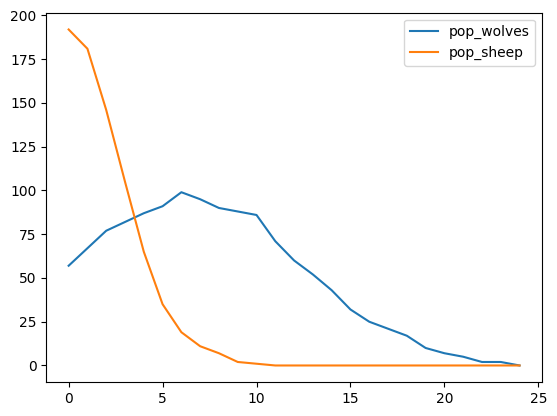

In [18]:
model.datacollector.get_model_vars_dataframe().plot()